In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from geopy.distance import geodesic
import os


In [29]:
# Load dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [30]:
print(df.isnull().sum())

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [31]:
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [32]:
scaler = StandardScaler()
numerical_cols = ['Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])


In [33]:
def extract_lat_long(s):
    lat, lng = s.replace('(','').replace(')','').split(',')
    return float(lat), float(lng)

df['Cust_lat'], df['Cust_long'] = zip(*df['Customer_Location'].apply(extract_lat_long))
df['Rest_lat'], df['Rest_long'] = zip(*df['Restaurant_Location'].apply(extract_lat_long))

df['Geo_Distance'] = df.apply(lambda row: geodesic((row['Cust_lat'], row['Cust_long']), (row['Rest_lat'], row['Rest_long'])).km, axis=1)



In [34]:
rush_hour_times = ['Morning', 'Evening'] 
df['Is_Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if x in rush_hour_times else 0)


In [35]:
threshold = df['Delivery_Time'].median()
df['Target'] = (df['Delivery_Time'] <= threshold).map({True: 'Fast', False: 'Delayed'})
label_encoder = LabelEncoder()
df['Target_Label'] = label_encoder.fit_transform(df['Target'])  # Fast=1, Delayed=0


In [36]:
def location_to_image(row, size=32):
    img = np.zeros((size, size), dtype=np.float32)
    x1 = int(size * ((row['Cust_lat'] + 90) / 180))
    y1 = int(size * ((row['Cust_long'] + 180) / 360))
    x2 = int(size * ((row['Rest_lat'] + 90) / 180))
    y2 = int(size * ((row['Rest_long'] + 180) / 360))
    img[x1, y1] = 1.0
    img[x2, y2] = 1.0
    return img

df['loc_image'] = df.apply(location_to_image, axis=1)
X_img = np.stack(df['loc_image'].values)
y = df['Target_Label'].values


In [37]:
model = models.Sequential([
    layers.Input(shape=(32, 32, 1)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_img, y, test_size=0.2, stratify=y, random_state=42
)


In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping( monitor='val_loss',     
    patience=4,            
    restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),callbacks=[early_stopping])


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.5065 - loss: 0.6935 - precision_11: 0.5077 - recall_11: 0.9695 - val_accuracy: 0.5500 - val_loss: 0.6926 - val_precision_11: 0.5417 - val_recall_11: 0.6500
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6320 - loss: 0.6918 - precision_11: 0.6083 - recall_11: 0.6796 - val_accuracy: 0.5500 - val_loss: 0.6921 - val_precision_11: 0.5556 - val_recall_11: 0.5000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5426 - loss: 0.6916 - precision_11: 0.5600 - recall_11: 0.5904 - val_accuracy: 0.5500 - val_loss: 0.6916 - val_precision_11: 0.5417 - val_recall_11: 0.6500
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5928 - loss: 0.6902 - precision_11: 0.5632 - recall_11: 0.7671 - val_accuracy: 0.5500 - val_loss: 0.6912 - val_precision_11: 0.5417 - val_recall_11: 0.6500
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5822 - loss: 0.6896 - precision_11: 0.5592 - recall_11: 0.73

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        20
           1       0.56      0.50      0.53        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40

Confusion Matrix:
 [[12  8]
 [10 10]]


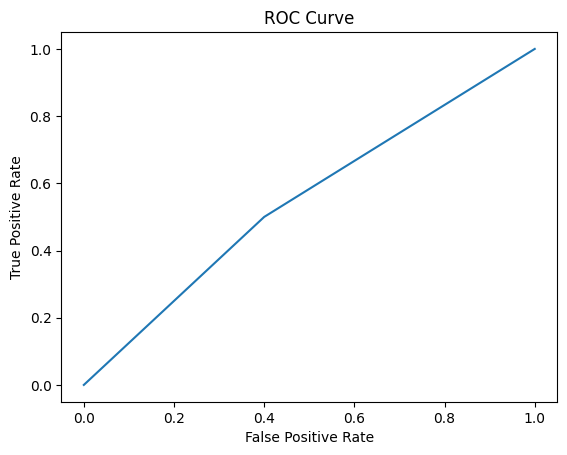

In [40]:
preds = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, preds))
fpr, tpr, _ = roc_curve(y_val, preds)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [41]:
# 5-fold stratified cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_prec, cv_recall, cv_f1 = [], [], [], []

for train_index, val_index in kf.split(X_img, y):
    Xtr, Xv = X_img[train_index], X_img[val_index]
    ytr, yv = y[train_index], y[val_index]
    model_cv = tf.keras.models.clone_model(model)
    model_cv.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model_cv.fit(Xtr, ytr, epochs=10, batch_size=32, verbose=0)
    preds_cv = (model_cv.predict(Xv) > 0.5).astype(int)
    report = classification_report(yv, preds_cv, output_dict=True)
    cv_acc.append(report['accuracy'])
    cv_prec.append(report['1']['precision'])
    cv_recall.append(report['1']['recall'])
    cv_f1.append(report['1']['f1-score'])

print(f"Mean CV Accuracy: {np.mean(cv_acc):.3f}")
print(f"Mean CV Precision: {np.mean(cv_prec):.3f}")
print(f"Mean CV Recall: {np.mean(cv_recall):.3f}")
print(f"Mean CV F1-score: {np.mean(cv_f1):.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Mean CV Accuracy: 0.545
Mean CV Precision: 0.542
Mean CV Recall: 0.590
Mean CV F1-score: 0.556


In [42]:
from sklearn.linear_model import LogisticRegression

# Use tabular features for logistic regression
X_tab = df_encoded[numerical_cols + [col for col in df_encoded.columns if any(cat in col for cat in categorical_cols)]].values
y_tab = df['Target_Label'].values
Xtr_tab, Xv_tab, ytr_tab, yv_tab = train_test_split(X_tab, y_tab, test_size=0.2, stratify=y_tab, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(Xtr_tab, ytr_tab)
preds_lr = lr.predict(Xv_tab)
print(classification_report(yv_tab, preds_lr))


              precision    recall  f1-score   support

           0       0.42      0.40      0.41        20
           1       0.43      0.45      0.44        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40

